This is the documentation for "Emotion Recognition from Brain Wave Using Multitask Machine Learning Leveraging Residual Connections" paper by

Rumman Ahmed Prodhan1[0000−0002−6865−185X], Sumya
Akter1[0000−0001−7114−1845], Muhammad Bin Mujib1[0000−0003−0283−3439], Md.
Akhtaruzzaman Adnan1[0000−0003−4137−0844], and *Tanmoy Sarkar Pias2[0000−0002−7325−9844]

1 University of Asia Pacific, Dhaka 1205, Bangladesh
rumman153@gmail.com, sumyaakter601@gmail.com, binmujib99@gmail.com,
adnan.cse@uap-bd.edu

2 Virginia Tech, Blacksburg, VA 24061, United States
tanmoysarkar@vt.edu
*Corresponding Author

Published in Springer: https://link.springer.com/chapter/10.1007/978-3-031-34622-4_10

https://doi.org/10.1007/978-3-031-34622-4_10

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


**Pyeeg has been installed**

In [ ]:
pip install git+https://github.com/forrestbao/pyeeg.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-n6hcvbmg
  Running command git clone -q https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-n6hcvbmg
  Created wheel for pyeeg: filename=pyeeg-0.4.4-py2.py3-none-any.whl size=28131 sha256=0c8063dd57dbae39e1b3477b206394b6ff0c293787af7d78aa218fba8764a664
  Stored in directory: /tmp/pip-ephem-wheel-cache-54qct0c8/wheels/b0/23/e4/703c908bda656959957029fa145879aa79307b2545a2ef0271
Successfully built pyeeg


**Here is the code for mounting google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyeeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Imported the necessery library packages**

In [ ]:
import numpy as np
import pyeeg as pe
import pickle as pickle
import pandas as pd
import math

from sklearn import svm
from sklearn.preprocessing import normalize

import os
import time

**Location of dat file and location for where to save preprocessed npy files**

In [ ]:
path_to_dataset_2 = '/content/drive/Shareddrives/DEAP EEG/Dataset/physiological_recordings/data_preprocessed_python/' #Location of dat file of DEAP dataset
path_to_dataset = '/content/drive/Shareddrives/DEAP EEG/Preprocessed_data/dataset_87.5-12.5_split/' #where to save preprocessed npy files

**Intialize the channel array, band array, window_size, step_size and sample_rate and set the path of dataset of google drive.**

In [ ]:
channel = [1,2,3,4,6,11,13,17,19,20,21,25,29,31] #14 Channels chosen to fit Emotiv Epoch+

band = [4,8,12,16,25,45] #5 bands

window_size = 256 #Averaging band power of 2 sec

step_size = 16 #Each 0.125 sec update once

sample_rate = 128 #Sampling rate of 128 Hz

subjectList=[] #taking an empty array to store subject numbers here
for i in range(1,33):
  if i<10:
     subjectList.append(f"{i:02d}") #to add extra '0' infront of 1 to 9 single digits
  else:
    subjectList.append(f"{i:2d}")


**Declaring FFT function. Taking the preprocessed dat file and converting it to a preprocessed npy file after FFT**

In [ ]:
def FFT_Processing (sub, channel, band, window_size, step_size, sample_rate):
    '''
    arguments:  string subject
                list channel indice
                list band
                int window size for FFT
                int step size for FFT
                int sample rate for FFT
    return:     void
    '''
    meta = []
    with open(path_to_dataset_2+'s' + sub + '.dat', 'rb') as file:

        subject = pickle.load(file, encoding='latin1') #resolve the python 2 data problem by encoding : latin1

        for i in range (0,40):
            # loop over 0-39 trails
            data = subject["data"][i]
            labels = subject["labels"][i]
            start = 0;

            while start + window_size < data.shape[1]:
                meta_array = []
                meta_data = [] #meta vector for analysis
                for j in channel:
                    X = data[j][start : start + window_size] #Slice raw data over 2 sec, at interval of 0.125 sec
                    Y = pe.bin_power(X, band, sample_rate) #FFT over 2 sec of channel j, in seq of theta, alpha, low beta, high beta, gamma
                    meta_data = meta_data + list(Y[0])

                meta_array.append(np.array(meta_data))
                meta_array.append(labels)

                meta.append(np.array(meta_array))
                start = start + step_size

        meta = np.array(meta)
        np.save(path_to_dataset+'s' + sub, meta, allow_pickle=True, fix_imports=True) #saving each of the 32 files as npy after preprocessing

**Calling the FFT functions for each subjects**

In [ ]:
for subjects in subjectList:
    FFT_Processing (subjects, channel, band, window_size, step_size, sample_rate)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
import numpy as np
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

##Dividing the Data into Training and Testing


#spliting and appending each npy into training, testing (87.5/12.5)
Dividing the 32 preprocessed npy file into data training, label training, data testing and label testing. Every npy file has 19520 rows and 4 columns which are valence, arousal, dominace and likings. Every npy file was divided by 8.

For each npy file

*   Training : 19520-2406=17114 (87.5%)
*   Testing : 19520/8=2406 (12.5%)

For training and testing
* The data training and label training both has 17114*32=547648 rows (87.5%)
* The data testing and label testing both has 2406*32=76992 rows (12.5%)









In [ ]:
data_training = []
label_training = []
data_testing = []
label_testing = []

for subjects in subjectList:

    with open(path_to_dataset + 's' + subjects + '.npy', 'rb') as file:
        sub = np.load(file) # loading npy file
        for i in range (0,sub.shape[0]): # running loop over 19520 rows
            if i % 8 == 0: # 19520/8=2440 (12.5%)
                data_testing.append(sub[i][0])
                label_testing.append(sub[i][1])
            else: # 19520-2406=17080 (87.5%)
                data_training.append(sub[i][0])
                label_training.append(sub[i][1])

In [ ]:
# restore np.load for future normal usage
np.load = np_load_old

**Saving the data training, label training, data testing and label testing into google drive**


In [ ]:
np.save(path_to_dataset + 'data_training', np.array(data_training), allow_pickle=True, fix_imports=True)
np.save(path_to_dataset + 'label_training', np.array(label_training), allow_pickle=True, fix_imports=True)
print("training dataset:", np.array(data_training).shape, np.array(label_training).shape)

np.save(path_to_dataset + 'data_testing', np.array(data_testing), allow_pickle=True, fix_imports=True)
np.save(path_to_dataset + 'label_testing', np.array(label_testing), allow_pickle=True, fix_imports=True)
print("testing dataset:", np.array(data_testing).shape, np.array(label_testing).shape)

training dataset: (546560, 70) (546560, 4)
testing dataset: (78080, 70) (78080, 4)


#For spliting the dataset to 1-22 and 23-32
Taking the npy file of participants 1-22 into training and 23-32 into testing.

* Training 19520*22 = 429440 (68.75%)
* Testing 19520*10 = 195200 (31.25%)



In [ ]:
data_training = []
label_training = []
data_testing = []
label_testing = []

for subjects in subjectList:

 with open('/content/drive/Shareddrives/DEAP EEG/Preprocessed_data/' + 's' + subjects + '.npy', 'rb') as file:
  sub = np.load(file)
  print(subjects)
  print(sub.shape[0])
  if int(subjects)<23:
    for i in range (0,sub.shape[0]):
       data_training.append(sub[i][0])
       label_training.append(sub[i][1])
  else:
    for i in range (0,sub.shape[0]):
        data_testing.append(sub[i][0])
        label_testing.append(sub[i][1])

**Saving the data training, label training, data testing and label testing into google drive**

In [ ]:
np.save(path_to_dataset + 'data_training', np.array(data_training), allow_pickle=True, fix_imports=True)
np.save(path_to_dataset + 'label_training', np.array(label_training), allow_pickle=True, fix_imports=True)
print("training dataset:", np.array(data_training).shape, np.array(label_training).shape)

np.save(path_to_dataset + 'data_testing', np.array(data_testing), allow_pickle=True, fix_imports=True)
np.save(path_to_dataset + 'label_testing', np.array(label_testing), allow_pickle=True, fix_imports=True)
print("testing dataset:", np.array(data_testing).shape, np.array(label_testing).shape)

#Adding familiarity

**Location of preprocessed npy file is path_to_dataset with 4 labels (valence, arousal, dominance, likings) and location for where to save preprocessed npy files with 5 labels (valence, arousal, dominance, likings, familiarity) after adding familiarity**

In [ ]:
path_to_dataset = '/content/drive/Shareddrives/DEAP EEG/Preprocessed_data/dataset_87.5-12.5_split/'  #preprocessed npy file with 4 labels (valence, arousal, dominance, likings)
npy_with_familiar = '/content/drive/Shareddrives/DEAP EEG/Preprocessed_data/familiarity_test/' #where to save preprocessed npy files with 5 labels after adding familiarity

**Importing participant ratings csv where the familiarity of each participants along valence, arousal, dominance, likings, Participant_id, Trial, Experiment_id, Start_time are available**

In [ ]:
df = pd.read_csv('/content/drive/Shareddrives/DEAP EEG/Dataset/metadata/metadata_csv/participant_ratings.csv')
df #1280x9

,Participant_id,Trial,Experiment_id,Start_time,Valence,Arousal,Dominance,Liking,Familiarity
0,1,1,5,1695918,6.96,3.92,7.19,6.05,4.0
1,1,2,18,2714905,7.23,7.15,6.94,8.01,4.0
2,1,3,4,3586768,4.94,6.01,6.12,8.06,4.0
3,1,4,24,4493800,7.04,7.09,8.01,8.22,4.0
4,1,5,20,5362005,8.26,7.91,7.19,8.13,1.0
...,...,...,...,...,...,...,...,...,...
1275,32,36,1,30916115,8.13,4.83,9.00,4.87,2.0
1276,32,37,18,31703107,8.03,7.06,8.96,8.18,5.0
1277,32,38,3,32482079,8.05,7.09,8.86,7.08,5.0
1278,32,39,25,33248922,4.01,7.17,8.01,6.94,2.0


**Dropping unnecessary columns (Participant_id, Trial, Experiment_id, Start_time) and saving it into a new dataframe with 1280x5**

In [ ]:
df_familiarity = df.drop(columns =['Participant_id','Trial','Experiment_id','Start_time']) #dropping unnecessary columns
df_familiarity #40x5

,Valence,Arousal,Dominance,Liking,Familiarity
0,6.96,3.92,7.19,6.05,4.0
1,7.23,7.15,6.94,8.01,4.0
2,4.94,6.01,6.12,8.06,4.0
3,7.04,7.09,8.01,8.22,4.0
4,8.26,7.91,7.19,8.13,1.0
...,...,...,...,...,...
1275,8.13,4.83,9.00,4.87,2.0
1276,8.03,7.06,8.96,8.18,5.0
1277,8.05,7.09,8.86,7.08,5.0
1278,4.01,7.17,8.01,6.94,2.0


**Creating a function to add familiarity. This function will load the preprocossed npy file with 4 labels (valence, arousal, dominance, likings) and will check common values with df_familiarity dataframe. This function will execute for 29 files as familiarity is missing for participants 2,15 and 23. For every participants it will first merge the labels with df_familiarity and the results will be saved to a new npy file with 5 labels (valence, arousal, dominance, likings, familiarity)**

In [ ]:
def add_familiarity(path_to_dataset,npy_with_familiar,subjects,df_familiarity):
    with open(path_to_dataset+'s' + subjects + '.npy', 'rb') as file: #open preprocessed npy with 4 labels (valence, arousal, dominance, likings)
      sub = np.load(file) #loading the npy file 19520x2. There is 2 column. 1 is for data and 1 is for label
    df2 = pd.DataFrame(sub) #converting the npy file into a dataframe

    df3=DataFrame(df2[1].tolist()) #spliting the label column into 4 separate column and saving it into a new dataframe
    df3.columns =['Valence', 'Arousal', 'Dominance', 'Liking'] #giving the columns headers

    merge_df = pd.merge(df3, df_familiarity, on=['Valence','Arousal','Dominance','Liking'], how='left') #merging 2 dataframe based on common 4 column

    merge_df['combined']= merge_df.values.tolist() #combining 5 columns into a single column called combined
    merge_df = merge_df.drop(columns =['Valence','Arousal','Dominance','Liking','Familiarity']) #droping 5 columns

    df2 = df2.drop(columns =[1]) #drop the original label column

    result = pd.concat([df2, merge_df], axis=1) #concating the combined column (5 labels) with data column

    sub2 = result.to_numpy() #saving the result to a numpy

    np.save(npy_with_familiar+'s' + str(subjects), sub2, allow_pickle=True, fix_imports=True) #saving the result to a new npy

**Calling the add_familiarity function. This function will execute for 29 files as familiarity is missing for participants 2,15 and 23. There was no issue to add familiarity for 25 participants. But for participant 13,27 and 31 we had to remove duplicate ratings from there individual ratings becuase they rated 5 labels(valence, arousal, dominance, likings, familiarity) with same values in 2 different trials. And had to handle participant 30 differently becuase in 2 trails valence,arousal,dominace and likings ratings where same but familiarity was different**

In [ ]:
from pandas import Series, DataFrame

for subjects in subjectList: #This function will execute for 29 files as familiarity is missing for participants 2,15 and 23.
  if (subjects == "02") or (subjects == "15") or (subjects == "23"): #skiping participant 2,15 and 23 because of missing familiarity
    pass
  elif (subjects == "13") or (subjects == "27") or (subjects == "31"): #handling participant 13,27 and 31 differently as they rated 5 labels same in some trials
      s_df = df.loc[df['Participant_id'] == int(subjects)] #selecting data for individual participant from participant ratings csv
      s_df = s_df.drop(columns =['Participant_id','Trial','Experiment_id','Start_time']) #dropping unnecessary columns
      s_df.drop_duplicates(keep='last',inplace=True) #remove duplicates among these 40 rows
      add_familiarity(path_to_dataset,npy_with_familiar,subjects,s_df) #calling the add familiarity function

  elif (subjects == "30"): #handling participant 30 differently becuase in 2 trails valence,arousal,dominace and likings ratings where same but familiarity was different
      s30_df = df.loc[df['Participant_id'] == 30] #selecting data for participant 30
      s30_df = s30_df.drop(columns =['Participant_id','Trial','Experiment_id','Start_time']) #dropping unnecessary columns
      s30_df.drop_duplicates(subset=['Valence','Arousal','Dominance','Liking'], keep='last',inplace=True) #this is for no. 30 participant only. becuase in 2 trails valence,arousal,dominace and likings ratings where same but familiarity was different

      add_familiarity(path_to_dataset,npy_with_familiar,subjects,s30_df)  #calling the add familiarity function
  else: #this will excecute of the remaining 25 participants
      add_familiarity(path_to_dataset,npy_with_familiar,subjects,df_familiarity)  #calling the add familiarity function

##Spliting and appending each npy into training, testing (87.5/12.5) after adding familiarity

In [ ]:
subjectList = ['01','03','04','05','06','07','08','09','10','11','12','13','14','16','17','18','19','20','21','22','24','25','26','27','28','29','30','31','32']

In [ ]:
data_training = []
label_training = []
data_testing = []
label_testing = []

for subjects in subjectList:
  if (subjects == "02") or (subjects == "15") or (subjects == "23"): #passing subject 2,15,23 as familiarity is not available for them
    pass
  else:
    with open(npy_with_familiar + 's' + subjects + '.npy', 'rb') as file:
        sub = np.load(file) # loading npy file
        for i in range (0,sub.shape[0]): # running loop over 19520 rows
            if i % 8 == 0: # 19520/8=2440 (12.5%)
                data_testing.append(sub[i][0])
                label_testing.append(sub[i][1])
            else: # 19520-2440=17080 (87.5%)
                data_training.append(sub[i][0])
                label_training.append(sub[i][1])

In [ ]:
np.save(npy_with_familiar + 'data_training', np.array(data_training), allow_pickle=True, fix_imports=True)
np.save(npy_with_familiar + 'label_training', np.array(label_training), allow_pickle=True, fix_imports=True)
print("training dataset:", np.array(data_training).shape, np.array(label_training).shape)

np.save(npy_with_familiar + 'data_testing', np.array(data_testing), allow_pickle=True, fix_imports=True)
np.save(npy_with_familiar + 'label_testing', np.array(label_testing), allow_pickle=True, fix_imports=True)
print("testing dataset:", np.array(data_testing).shape, np.array(label_testing).shape)

training dataset: (495320, 70) (495320, 5)
testing dataset: (70760, 70) (70760, 5)


#Loading the training file

**Here all the training file have been loaded .The data have been put in variable X and label values have been put in Y.Then the X has been Normalized and then valence label values have been loaded in Z. And then all the '9' values are converted into '8.99' of valence label.**

In [ ]:
with open(path_to_dataset + 'data_training.npy', 'rb') as fileTrain:
    X  = np.load(fileTrain)

with open(path_to_dataset + 'label_training.npy', 'rb') as fileTrainL:
    Y  = np.load(fileTrainL)

X = normalize(X)
Z = np.ravel(Y[:, [0]])

Valence_Train = np.ravel(Y[:, [0]])
Arousal_Train = np.ravel(Y[:, [1]])
Domain_Train = np.ravel(Y[:, [2]])
Like_Train = np.ravel(Y[:, [3]])

for i in range(len(Z)):
  if Z[i] == 9:
    Z[i] = 8.99

**This is for multitask learning model only.**

Here all the training file have been loaded .The data have been put in variable X and label values have been put in Y.Then the X has been Normalized and then arousal label values have been loaded in Valence_Train, Arousal_Train, Domain_Train,Like_Train, Familiar_Train. And then all the '9' values are converted into '8.99' of valence label.

In [ ]:
with open(npy_with_familiar + 'data_training.npy', 'rb') as fileTrain:
    X  = np.load(fileTrain)

with open(npy_with_familiar + 'label_training.npy', 'rb') as fileTrainL:
    Y  = np.load(fileTrainL)

X = normalize(X)
#Z = np.ravel(Y[:])

Valence_Train = np.ravel(Y[:, [0]])
Arousal_Train = np.ravel(Y[:, [1]])
Domain_Train = np.ravel(Y[:, [2]])
Like_Train = np.ravel(Y[:, [3]])
Familiar_Train = np.ravel(Y[:, [4]])

for i in range(len(Valence_Train)):
  if Valence_Train[i] == 9:
    Valence_Train[i] = 8.99
  if Arousal_Train[i] == 9:
    Arousal_Train[i] = 8.99
  if Domain_Train[i] == 9:
    Domain_Train[i] = 8.99
  if Like_Train[i] == 9:
    Like_Train[i] = 8.99

**All the training label values are divided into two segments. One segment contains values from 1 - 4.9 and another contains rest of the range's values. This approch is maintained for valence, arousal, dominance, likings binary classifications but not for other class classification.**


In [ ]:
count_0 = 0
count_1 = 0
for i in range(len(Z)):
  if Z[i] >= 1 and Z[i]<=4.99:
    Z [i] = 0
    count_0 = count_0 + 1
  else:
    Z [i] = 1
    count_1 = count_1 + 1
print(count_0,count_1)

237412 309148


**This is for multitask learning model only**

All the training label values are divided into two segments. One segment contains values from 1 - 4.9 and another contains rest of the range's values.

In [ ]:
def Two_Class(Valence_Train):
  countv_0 = 0
  countv_1 = 0
  for i in range(len(Valence_Train)):
    if Valence_Train[i] >= 1 and Valence_Train[i]<=4.99:
      Valence_Train[i] = 0
      countv_0 = countv_0 + 1
    elif Valence_Train[i] >= 5 and Valence_Train[i]<=8.99:
      Valence_Train[i] = 1
      countv_1 = countv_1 + 1
  print(countv_0,countv_1)


**This is for multitask learning model only calling the 2 class diving function**

In [ ]:
Two_Class(Valence_Train)
Two_Class(Arousal_Train)
Two_Class(Domain_Train)
Two_Class(Like_Train)

216916 278404
198128 297192
189588 305732
161833 333487


**Function for dividing into 3 classes**

In [ ]:
def Three_Class(Valence_Train):
  countv_0 = 0
  countv_1 = 0
  countv_2 = 0
  for i in range(len(Valence_Train)):
    if Valence_Train[i] >= 1 and Valence_Train[i]<=3.66:
      Valence_Train[i] = 0
      countv_0 = countv_0 + 1
    elif Valence_Train[i] >= 3.67 and Valence_Train[i]<=6.33:
      Valence_Train[i] = 1
      countv_1 = countv_1 + 1
    elif Valence_Train[i] >= 6.34 and Valence_Train[i]<=8.99:
      Valence_Train[i] = 2
      countv_2 = countv_2 + 1
  print(countv_0,countv_1,countv_2)

**This is for multitask learning model only**
**calling the 3 class diving function**

In [ ]:
Three_Class(Valence_Train)
Three_Class(Arousal_Train)
Three_Class(Domain_Train)
Three_Class(Like_Train)

121695 200690 172935
114863 229299 151158
112301 229726 153293
108458 183183 203679


**for familiarity each of 1 to 5 divided into 5 discrete classes**

In [ ]:
countv_0 = 0
countv_1 = 0
countv_2 = 0
countv_3 = 0
countv_4 = 0

for i in range(len(Familiar_Train)):
    if Familiar_Train[i] == 1:
      Familiar_Train[i] = 0
      countv_0 = countv_0 + 1
    elif Familiar_Train[i] == 2:
      Familiar_Train[i] = 1
      countv_1 = countv_1 + 1
    elif Familiar_Train[i] == 3:
      Familiar_Train[i] = 2
      countv_2 = countv_2 + 1
    elif Familiar_Train[i] == 4:
      Familiar_Train[i] = 3
      countv_3 = countv_3 + 1
    elif Familiar_Train[i] == 5:
      Familiar_Train[i] = 4
      countv_4 = countv_4 + 1

**Necessery libraries are imported**


In [ ]:
import pandas as pd
import keras.backend as K
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from tensorflow.keras.utils import to_categorical
import keras
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as K
from keras.models import Model
import timeit
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution1D, MaxPooling1D, ZeroPadding1D
import warnings
warnings.filterwarnings('ignore')
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation
from keras.regularizers import l2
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.layers import Input
from keras.utils.vis_utils import plot_model

**Here all the training label values are categorised. For binary classification and it is catagorised into two catagory. value range 1 - 4.99 have been assigned in catagory '0' and rest of the value are assigned in catagory '1'.**

1.  1-4.99 ----> catagory(0)
2.  5-8.99 ----> catagory(1)

In [ ]:
y_train = to_categorical(Z)
y_train[:10]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

**This is for multitask learning model only**

Here all the training label values are categorized. For binary classification and it is categorized into two category. value range 1 - 4.99 have been assigned in category '0' and rest of the value are assigned in category '1' for valence, arousal, dominance and likings.

* 1-4.99 ----> category(0)
* 5-8.99 ----> category(1)

For familiarity value range from 1-3 have been assigned in category '0' and rest of the value are assigned in category '1'

* 1-3 ----> category(0)
* 4-5 ----> category(1)

In [ ]:
from tensorflow.keras.utils import to_categorical
y1_train = to_categorical(Valence_Train)
y2_train = to_categorical(Arousal_Train)
y3_train = to_categorical(Domain_Train)
y4_train = to_categorical(Like_Train)
y5_train = to_categorical(Familiar_Train)

**Values of X are put in x_train as numpy array format**

In [ ]:
x_train = np.array(X[:])

**Here all the testing file have been loaded .The data have been put in variable M and label values have been put in N.Then the M has been Normalized and then valence label values have been loaded in L. And then all the '9' values are converted into '8.99' of valence label.**

In [ ]:
with open(path_to_dataset + 'data_testing.npy', 'rb') as fileTrain:
    M  = np.load(fileTrain)

with open(path_to_dataset + 'label_testing.npy', 'rb') as fileTrainL:
    N  = np.load(fileTrainL)

M = normalize(M)
L = np.ravel(N[:, [0]])


Valence_Test = np.ravel(N[:, [0]])
Arousal_Test = np.ravel(N[:, [1]])
Domain_Test = np.ravel(N[:, [2]])
Like_Test = np.ravel(N[:, [3]])

for i in range(len(L)):
  if L[i] == 9:
    L[i] = 8.99

**This is for multitask learning model only**

Here all the testing file have been loaded .The data have been put in variable M and label values have been put in N.Then the M has been Normalized and then valence label values have been loaded in Valence_Test, Arousal_Test, Domain_Test, Like_Test, Familiar_Test. And then all the '9' values are converted into '8.99' of valence label.

In [ ]:
with open(npy_with_familiar + 'data_testing.npy', 'rb') as fileTrain:
    M  = np.load(fileTrain)

with open(npy_with_familiar + 'label_testing.npy', 'rb') as fileTrainL:
    N  = np.load(fileTrainL)

M = normalize(M)
#L = np.ravel(N[:, [0]])

Valence_Test = np.ravel(N[:, [0]])
Arousal_Test = np.ravel(N[:, [1]])
Domain_Test = np.ravel(N[:, [2]])
Like_Test = np.ravel(N[:, [3]])
Familiar_Test = np.ravel(N[:, [4]])

for i in range(len(Valence_Test)):
  if Valence_Test[i] == 9:
    Valence_Test[i] = 8.99
  if Arousal_Test[i] == 9:
    Arousal_Test[i] = 8.99
  if Domain_Test[i] == 9:
    Domain_Test[i] = 8.99
  if Like_Test[i] == 9:
    Like_Test[i] = 8.99

**All the testing labels values are divided into two segments. One segment contains values from 1 - 4.9 and another contains rest of the range's values. This approch is maintained for valence, arousal, dominance, likings binary classifications but not for other class classification.**

In [ ]:
count_0 = 0
count_1 = 0
for i in range(len(L)):
  if L[i] >= 1 and L[i]<=4.99:
    L [i] = 0
    count_0 = count_0 + 1
  else:
    L [i] = 1
    count_1 = count_1 + 1
print(count_0,count_1)

33916 44164


**This is for multitask learning model only**

All the testing label values are divided into two segments. One segment contains values from 1 - 4.9 and another contains rest of the range's values.

In [ ]:
Two_Class(Valence_Test)
Two_Class(Arousal_Test)
Two_Class(Domain_Test)
Two_Class(Like_Test)

30988 39772
28304 42456
27084 43676
23119 47641


**3 class**

In [ ]:
Three_Class(Valence_Test)
Three_Class(Arousal_Test)
Three_Class(Domain_Test)
Three_Class(Like_Test)

17385 28670 24705
16409 32757 21594
16043 32818 21899
15494 26169 29097


for familiarity each of 1 to 5 divided into 5 discrete classes

In [ ]:
countv_0 = 0
countv_1 = 0
countv_2 = 0
countv_3 = 0
countv_4 = 0

for i in range(len(Familiar_Test)):
    if Familiar_Test[i] == 1:
      Familiar_Test[i] = 0
      countv_0 = countv_0 + 1
    elif Familiar_Test[i] == 2:
      Familiar_Test[i] = 1
      countv_1 = countv_1 + 1
    elif Familiar_Test[i] == 3:
      Familiar_Test[i] = 2
      countv_2 = countv_2 + 1
    elif Familiar_Test[i] == 4:
      Familiar_Test[i] = 3
      countv_3 = countv_3 + 1
    elif Familiar_Test[i] == 5:
      Familiar_Test[i] = 4
      countv_4 = countv_4 + 1

**Vules of M are assigned in x_test in numpy array format**

In [ ]:
x_test = np.array(M[:])
x_test

array([[0.07006464, 0.10438554, 0.06634758, ..., 0.10698754, 0.14264875,
        0.12007955],
       [0.07546743, 0.08606705, 0.07999725, ..., 0.12147734, 0.13970255,
        0.12824657],
       [0.11370435, 0.09387804, 0.07056466, ..., 0.11339237, 0.11484593,
        0.10770615],
       ...,
       [0.17484635, 0.1135094 , 0.05917121, ..., 0.03334964, 0.05135839,
        0.07198122],
       [0.20681713, 0.10186689, 0.0540274 , ..., 0.02499636, 0.05249084,
        0.05879238],
       [0.17817637, 0.08834064, 0.05389381, ..., 0.03475489, 0.05801423,
        0.06873259]])

**Here all the tessting labels values are categorised. For binary classification and it is catagorised into two catagory. value range 1 - 4.99 have been assigned in catagory '0' and rest of the value are assigned in catagory '1'.**

* 1-4.99 ----> catagory(0)
* 5-8.99 ----> catagory(1)

In [ ]:
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(L)

**This is for multitask learning model only**

Here all the training label values are categorized. For binary classification and it is categorized into two category. value range 1 - 4.99 have been assigned in category '0' and rest of the value are assigned in category '1' for valence, arousal, dominance and likings.

* 1-4.99 ----> category(0)
* 5-8.99 ----> category(1)

For familiarity value range from 1-3 have been assigned in category '0' and rest of the value are assigned in category '1'

* 1-3 ----> category(0)
* 4-5 ----> category(1)

In [ ]:
from tensorflow.keras.utils import to_categorical
y1_test = to_categorical(Valence_Test)
y2_test = to_categorical(Arousal_Test)
y3_test = to_categorical(Domain_Test)
y4_test = to_categorical(Like_Test)
y5_test = to_categorical(Familiar_Test)

**Fit the train and test data with StandarScaler**

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

**Two dimensional data are converted into three dimension by adding one constant dimension’s value '1'**

In [ ]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)

**Here define the batch_size, number of class used in model architecture ,how many epoch will be run with the model and also define the input_shape.**

In [ ]:
batch_size = 256
#num_classes = 2
epochs = 100

input_shape=(x_train.shape[1], 1)

## Residual Connection Example Network

# Example 1

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 70, 1)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 70, 1024)     7168        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 70, 1024)    4096        ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 35, 1024)     0           ['batch_normalization[0][0]']

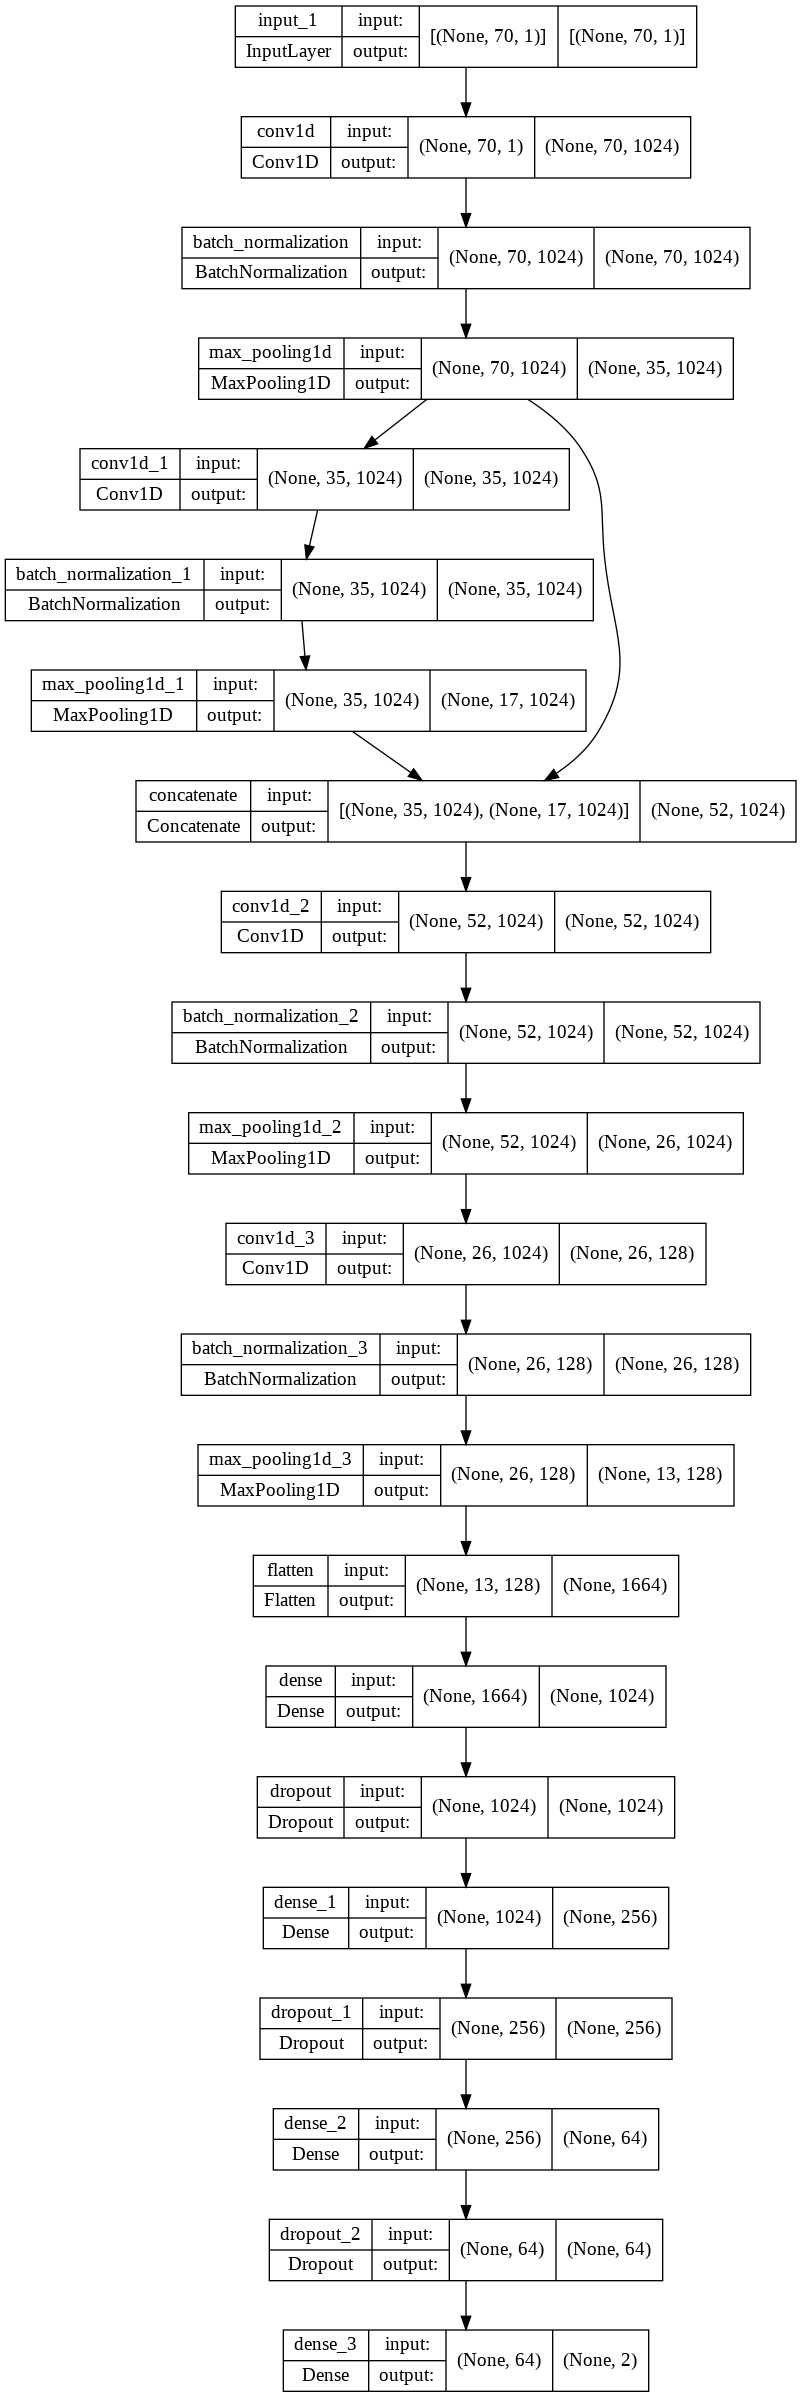

In [ ]:
intput_shape=(70, 1) #x_train.shape[1]

input_layer = Input(intput_shape)

conv1 = Conv1D(1024, kernel_size=6,padding = 'same',activation='relu') (input_layer)
bn1 = BatchNormalization() (conv1)
pool1 = MaxPooling1D(pool_size=(2)) (bn1)

conv2 = Conv1D(1024,kernel_size=6,padding = 'same', activation='relu') (pool1)
bn2 = BatchNormalization() (conv2)
pool2 = MaxPooling1D(pool_size=(2)) (bn2)

connect1 = concatenate([pool1, pool2], axis = 1)

conv3 = Conv1D(1024,kernel_size=6,padding = 'same', activation='relu') (connect1)
bn3 = BatchNormalization() (conv3)
pool3 = MaxPooling1D(pool_size=(2)) (bn3)

conv4 = Conv1D(128,kernel_size=6,padding = 'same', activation='relu') (pool3)
bn4 = BatchNormalization() (conv4)
pool4 = MaxPooling1D(pool_size=(2)) (bn4)

flat = Flatten() (pool4)

dense1 = Dense(1024, activation='relu') (flat)
drop1 = Dropout(0.2) (dense1)

dense2 = Dense(256, activation='relu') (drop1)
drop2 = Dropout(0.2) (dense2)

dense3 = Dense(64, activation='relu') (drop2)
drop3 = Dropout(0.2) (dense3)

output_layer = Dense(2, activation='softmax') (drop3) #num_classes

model = Model(input_layer, output_layer)
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

**Compiling the model**

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

#Example 2

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 70, 1)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 70, 1024)     7168        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 70, 1024)    4096        ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 35, 1024)     0           ['batch_normalization[0][0]']

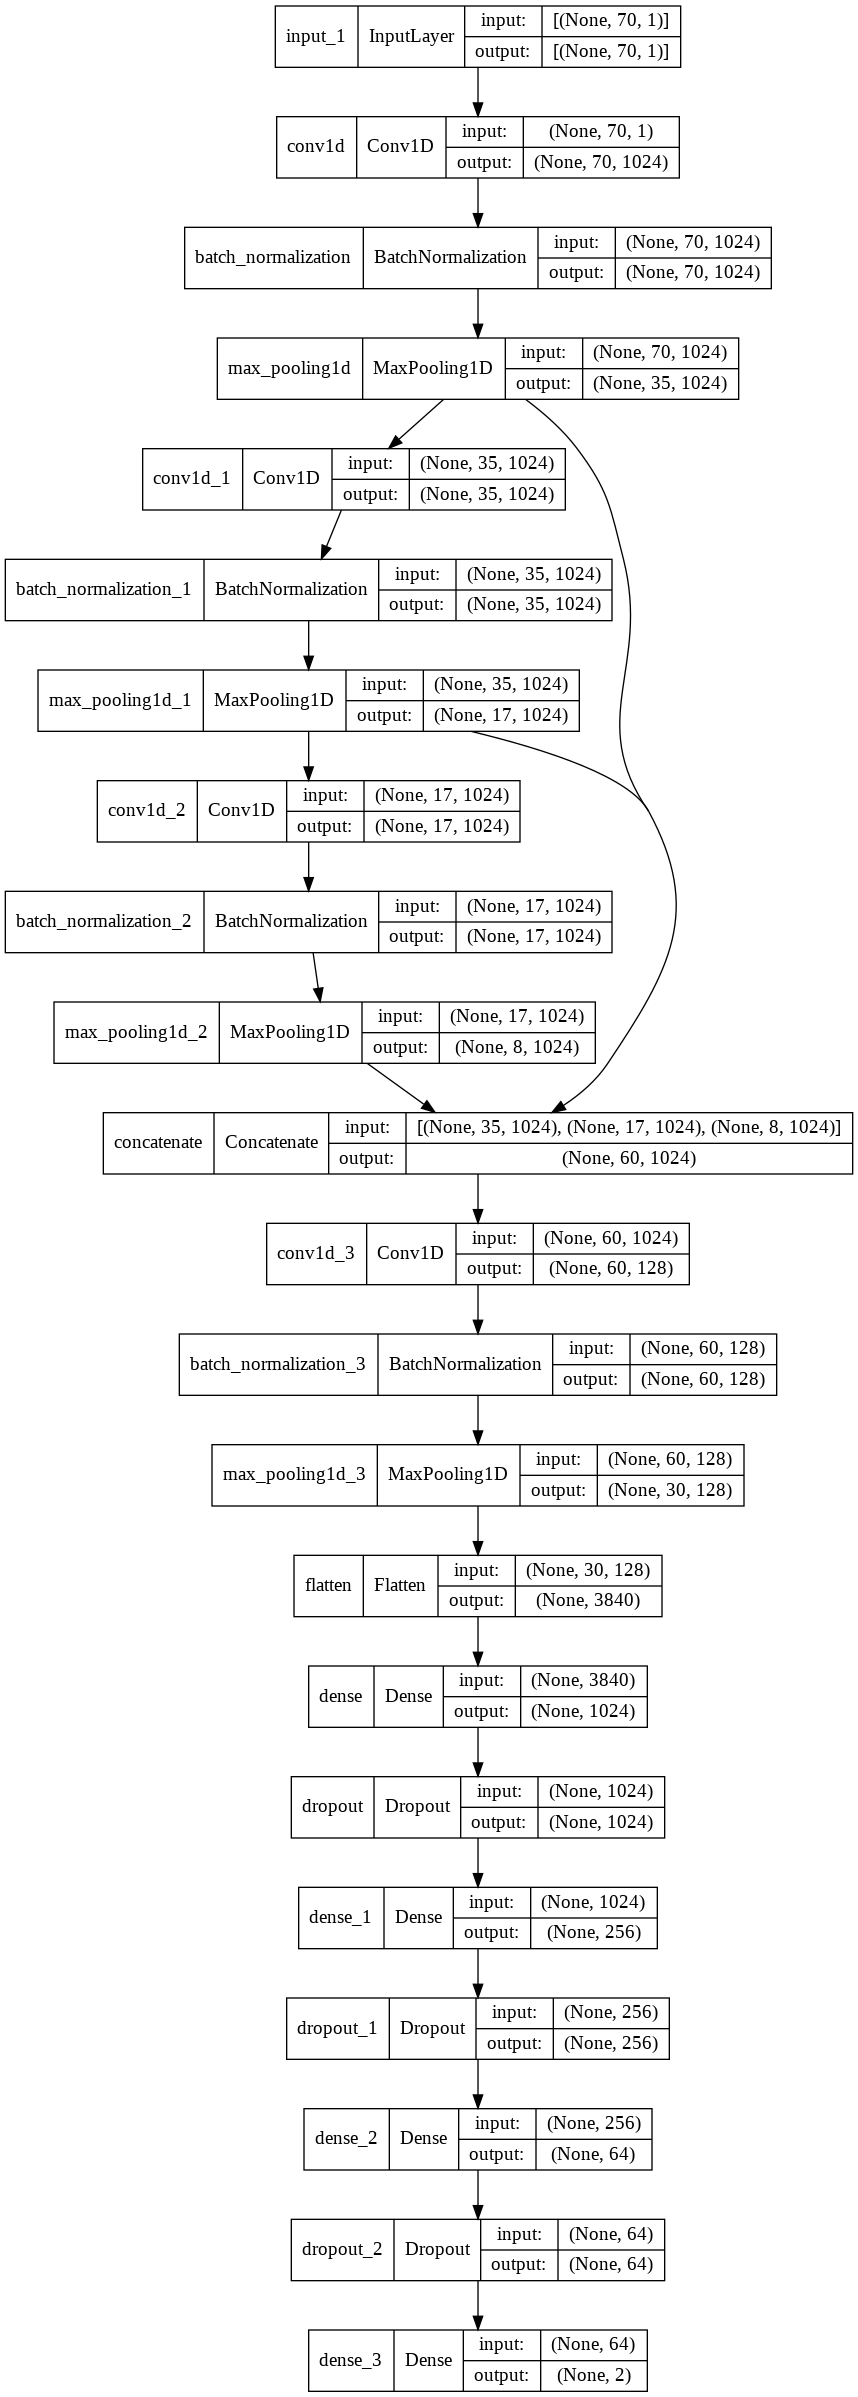

In [ ]:
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.utils.vis_utils import plot_model


intput_shape=(70, 1) #x_train.shape[1]

input_layer = Input(intput_shape)

conv1 = Conv1D(1024, kernel_size=6,padding = 'same',activation='relu') (input_layer)
bn1 = BatchNormalization() (conv1)
pool1 = MaxPooling1D(pool_size=(2)) (bn1)

conv2 = Conv1D(1024,kernel_size=6,padding = 'same', activation='relu') (pool1)
bn2 = BatchNormalization() (conv2)
pool2 = MaxPooling1D(pool_size=(2)) (bn2)


conv3 = Conv1D(1024,kernel_size=6,padding = 'same', activation='relu') (pool2)
bn3 = BatchNormalization() (conv3)
pool3 = MaxPooling1D(pool_size=(2)) (bn3)

connect1 = concatenate([pool1, pool2, pool3], axis=1)

conv4 = Conv1D(128,kernel_size=6,padding = 'same', activation='relu') (connect1)
bn4 = BatchNormalization() (conv4)
pool4 = MaxPooling1D(pool_size=(2)) (bn4)

flat = Flatten() (pool4)

dense1 = Dense(1024, activation='relu') (flat)
drop1 = Dropout(0.2) (dense1)

dense2 = Dense(256, activation='relu') (drop1)
drop2 = Dropout(0.2) (dense2)

dense3 = Dense(64, activation='relu') (drop2)
drop3 = Dropout(0.2) (dense3)

output_layer = Dense(2, activation='softmax') (drop3) #num_classes

model = Model(input_layer, output_layer)
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

**Compiling the model**

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

# Example 2.4 (multitask learning on model 2)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 70, 1)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 70, 1024)     7168        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 70, 1024)    4096        ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 35, 1024)     0           ['batch_normalization[0][0]']

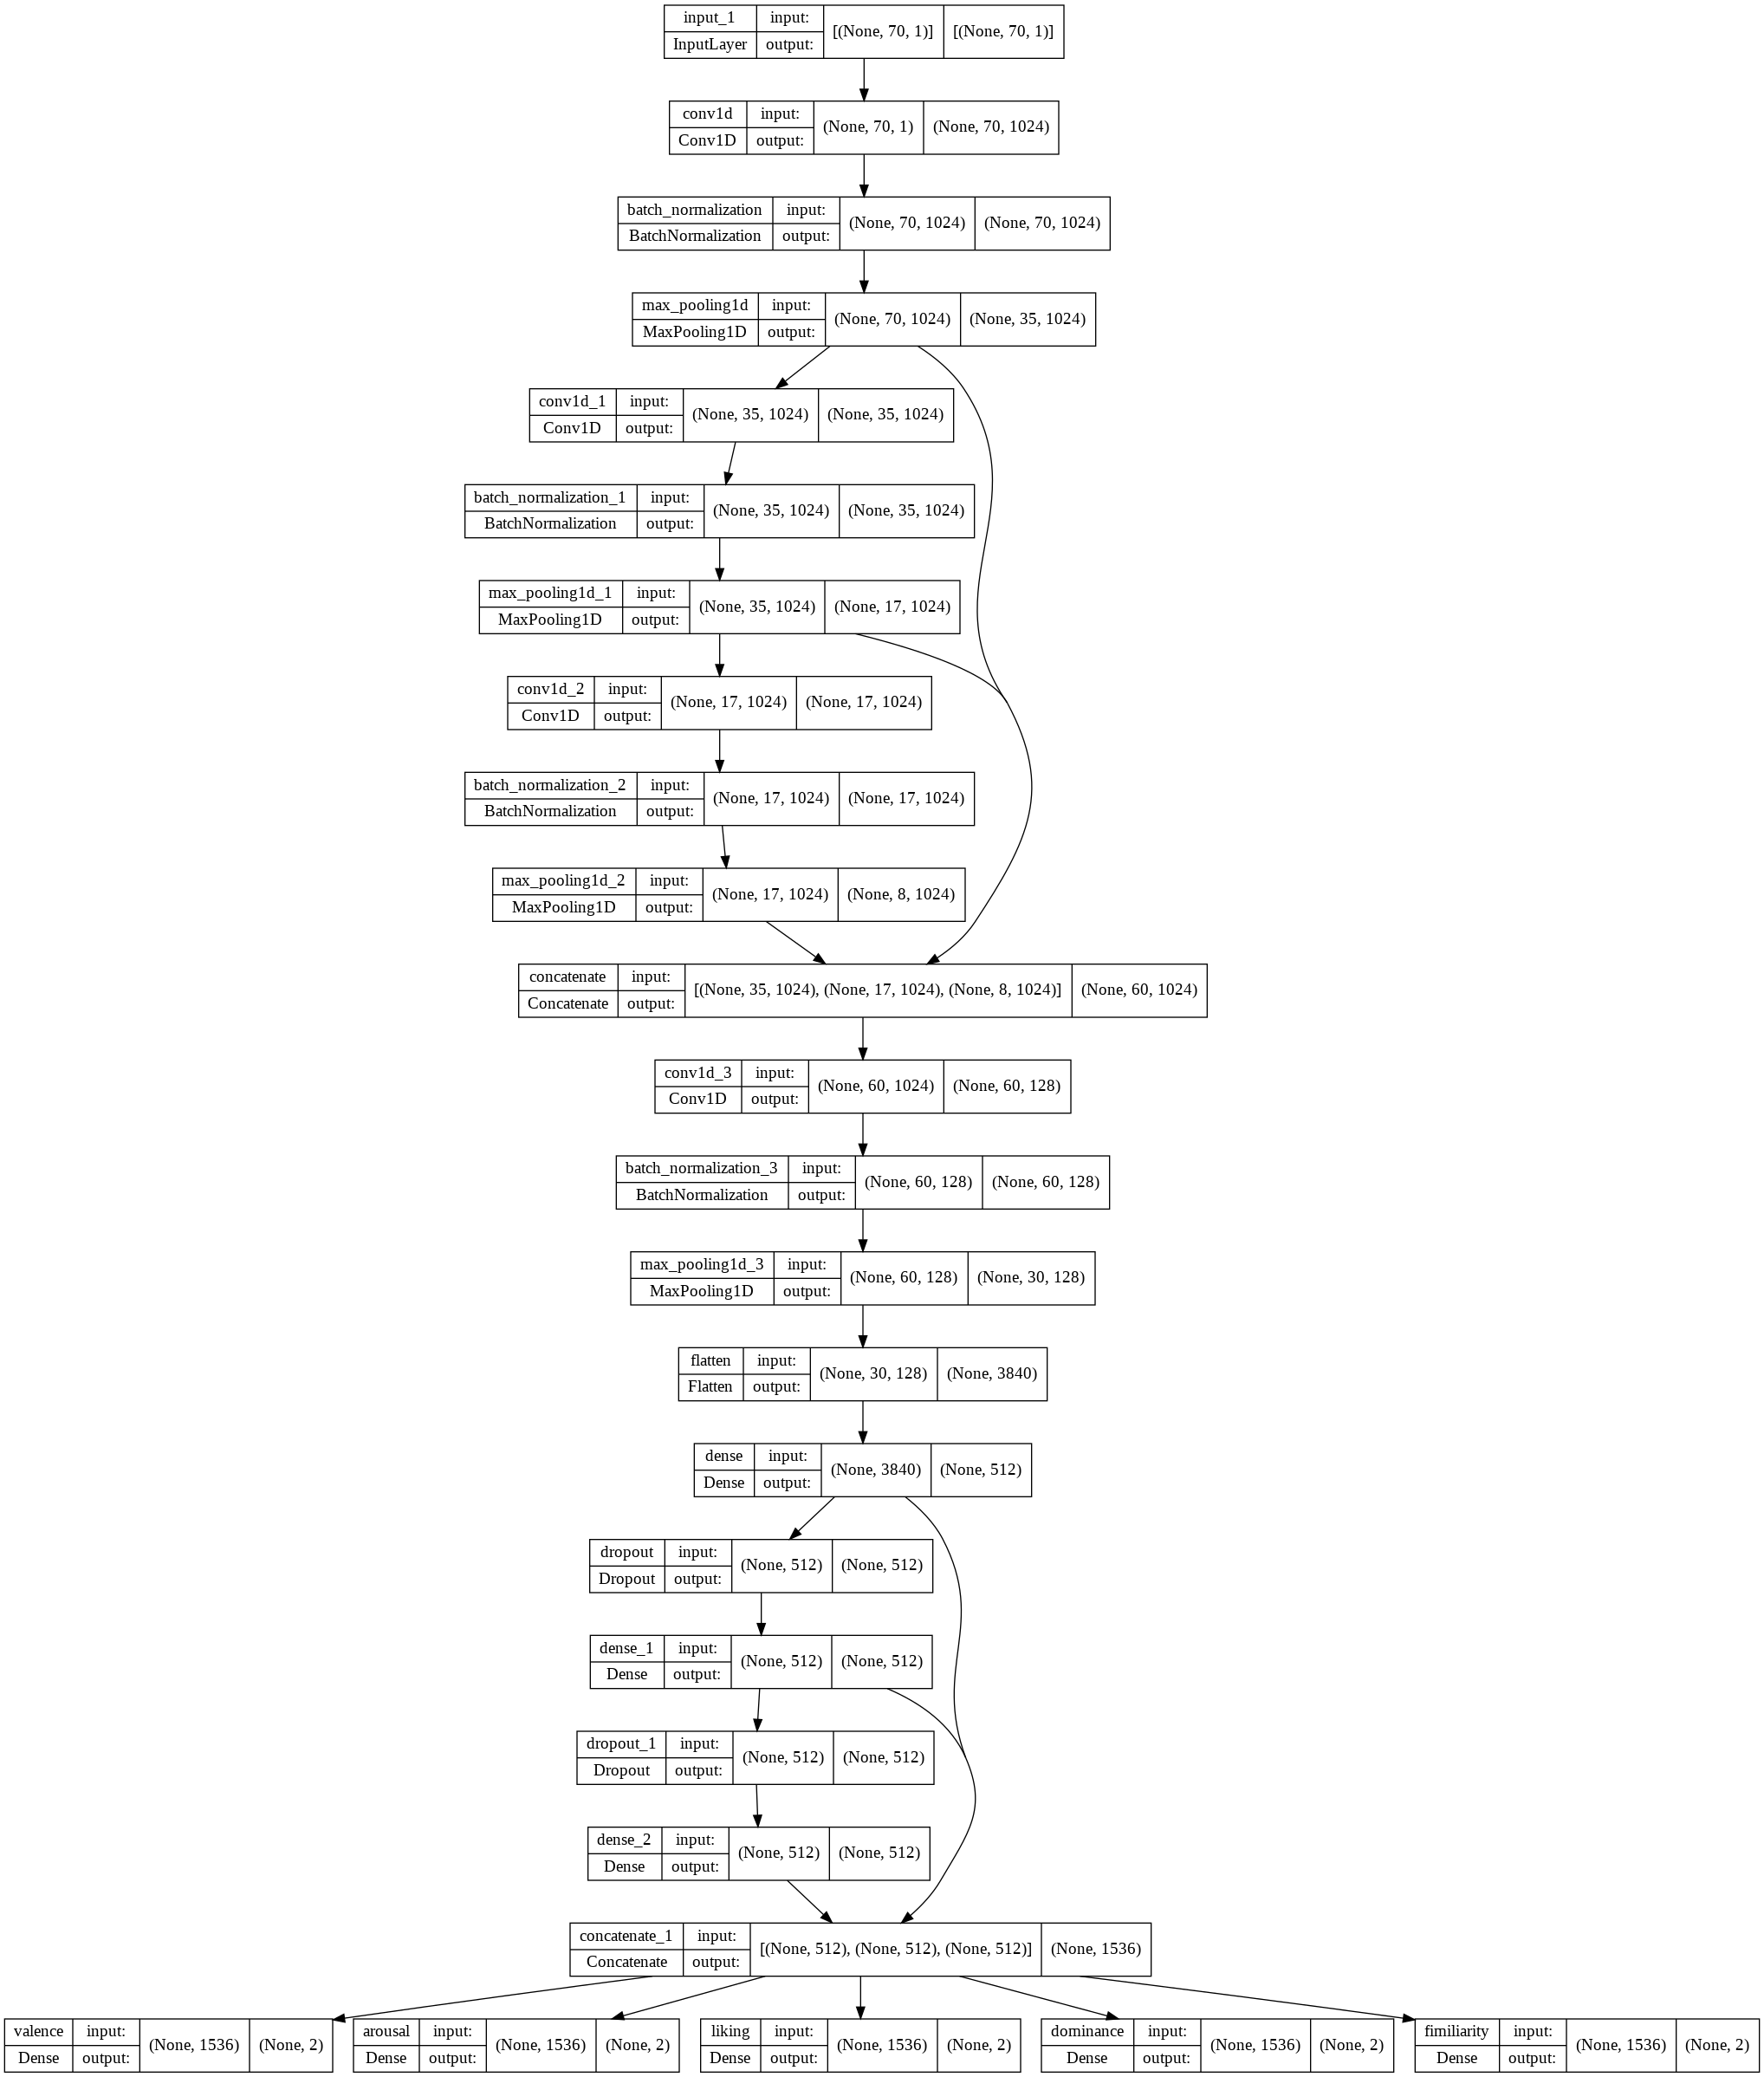

In [ ]:
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.utils.vis_utils import plot_model


intput_shape=(70, 1) #x_train.shape[1]

input_layer = Input(intput_shape)

conv1 = Conv1D(1024, kernel_size=6,padding = 'same',activation='relu') (input_layer)
bn1 = BatchNormalization() (conv1)
pool1 = MaxPooling1D(pool_size=(2)) (bn1)

conv2 = Conv1D(1024,kernel_size=6,padding = 'same', activation='relu') (pool1)
bn2 = BatchNormalization() (conv2)
pool2 = MaxPooling1D(pool_size=(2)) (bn2)


conv3 = Conv1D(1024,kernel_size=6,padding = 'same', activation='relu') (pool2)
bn3 = BatchNormalization() (conv3)
pool3 = MaxPooling1D(pool_size=(2)) (bn3)

connect1 = concatenate([pool1, pool2, pool3], axis=1)

conv4 = Conv1D(128,kernel_size=6,padding = 'same', activation='relu') (connect1)
bn4 = BatchNormalization() (conv4)
pool4 = MaxPooling1D(pool_size=(2)) (bn4)

flat = Flatten() (pool4)

dense1 = Dense(512, activation='relu') (flat)
drop1 = Dropout(0.3) (dense1)

dense2 = Dense(512, activation='relu') (drop1)
drop2 = Dropout(0.3) (dense2)

dense3 = Dense(512, activation='relu') (drop2)
drop3 = Dropout(0.3) (dense3)

connect4 = concatenate([dense1, dense2, dense3])

output_layer_val = Dense(2, activation='softmax', name = "valence") (connect4) #num_classes
output_layer_aro = Dense(2, activation='softmax', name= 'arousal') (connect4) #num_classes
output_layer_lik = Dense(2, activation='softmax', name = 'liking') (connect4) #num_classes
output_layer_dom = Dense(2, activation='softmax', name = 'dominance') (connect4) #num_classes
output_layer_fim = Dense(2, activation='softmax', name = 'fimiliarity') (connect4) #num_classes

model = Model(
    inputs = input_layer,
    outputs = [output_layer_val, output_layer_aro, output_layer_lik, output_layer_dom, output_layer_fim])
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

**Compiling the model**

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

#Example 3

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 70, 1)]      0           []                               
                                                                                                  
 conv1d_4 (Conv1D)              (None, 70, 512)      3584        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 70, 512)     2048        ['conv1d_4[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 max_pooling1d_4 (MaxPooling1D)  (None, 35, 512)     0           ['batch_normalization_4[0][

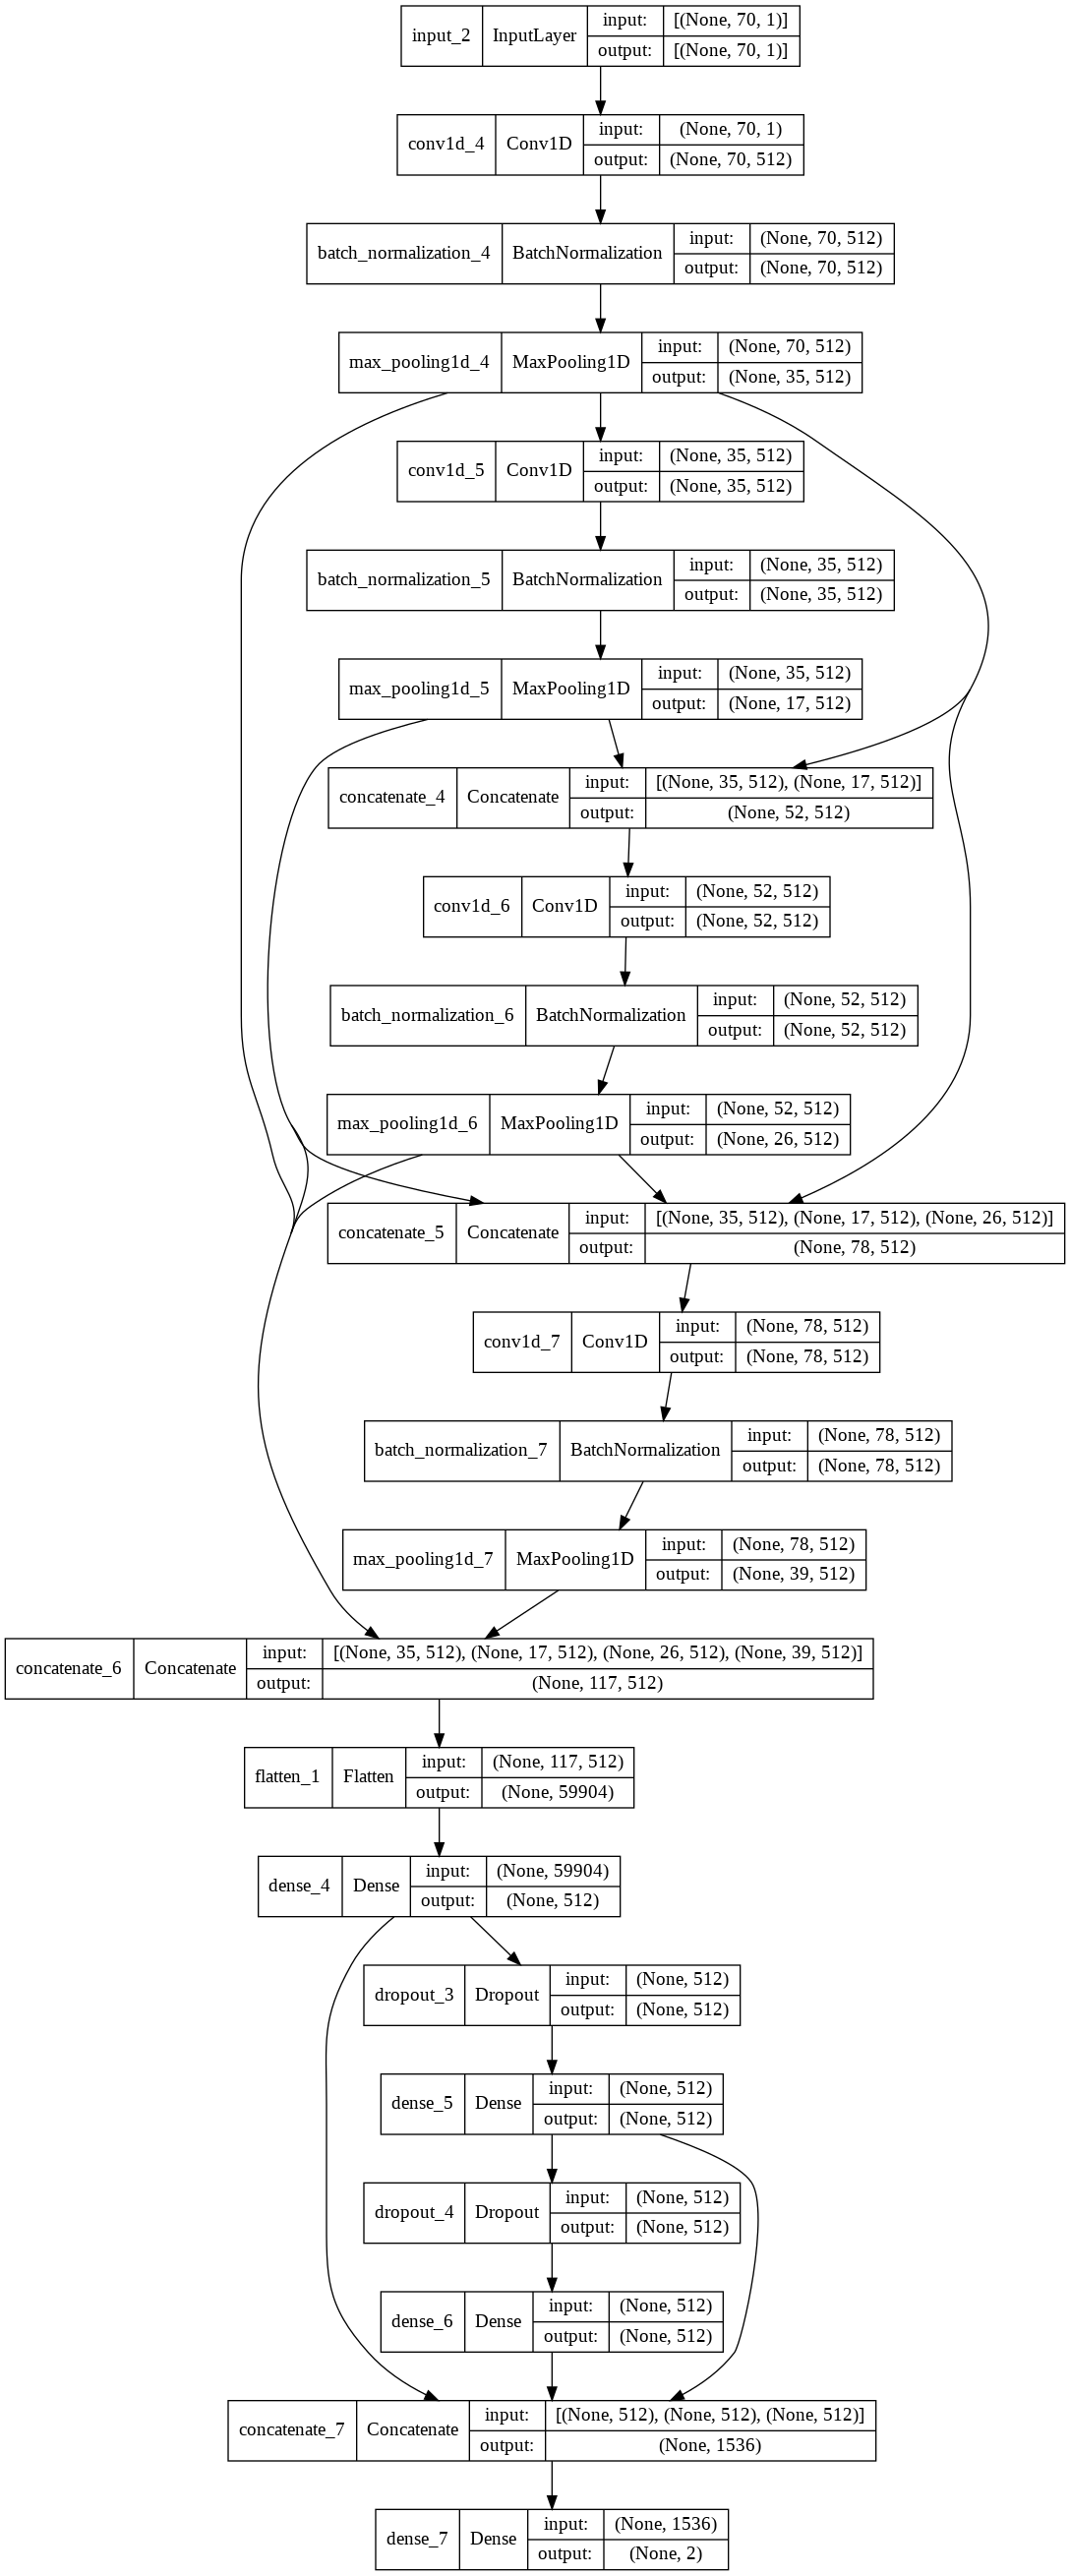

In [ ]:
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.utils.vis_utils import plot_model


intput_shape=(70, 1) #x_train.shape[1]

input_layer = Input(intput_shape)

conv1 = Conv1D(512, kernel_size=6,padding = 'same',activation='relu') (input_layer)
bn1 = BatchNormalization() (conv1)
pool1 = MaxPooling1D(pool_size=(2)) (bn1)

conv2 = Conv1D(512,kernel_size=6,padding = 'same', activation='relu') (pool1)
bn2 = BatchNormalization() (conv2)
pool2 = MaxPooling1D(pool_size=(2)) (bn2)

connect1 = concatenate([pool1, pool2], axis=1)

conv3 = Conv1D(512,kernel_size=6,padding = 'same', activation='relu') (connect1)
bn3 = BatchNormalization() (conv3)
pool3 = MaxPooling1D(pool_size=(2)) (bn3)

connect2 = concatenate([pool1, pool2, pool3], axis=1)

conv4 = Conv1D(512,kernel_size=6,padding = 'same', activation='relu') (connect2)
bn4 = BatchNormalization() (conv4)
pool4 = MaxPooling1D(pool_size=(2)) (bn4)

connect3 = concatenate([pool1, pool2, pool3, pool4], axis=1)

flat = Flatten() (connect3)

dense1 = Dense(512, activation='relu') (flat)
drop1 = Dropout(0.3) (dense1)

dense2 = Dense(512, activation='relu') (drop1)
drop2 = Dropout(0.3) (dense2)

dense3 = Dense(512, activation='relu') (drop2)
drop3 = Dropout(0.3) (dense3)

connect4 = concatenate([dense1, dense2, dense3])

output_layer = Dense(2, activation='softmax') (connect4) #num_classes

model = Model(
    inputs = input_layer,
    outputs = output_layer)
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

# Model 4


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 70, 1)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 70, 2048)     8192        ['input_1[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 70, 2048)    0           ['conv1d[0][0]']                 
 out1D)                                                                                           
                                                                                                  
 batch_normalization (BatchNorm  (None, 70, 2048)    8192        ['spatial_dropout1d[0][0]']  

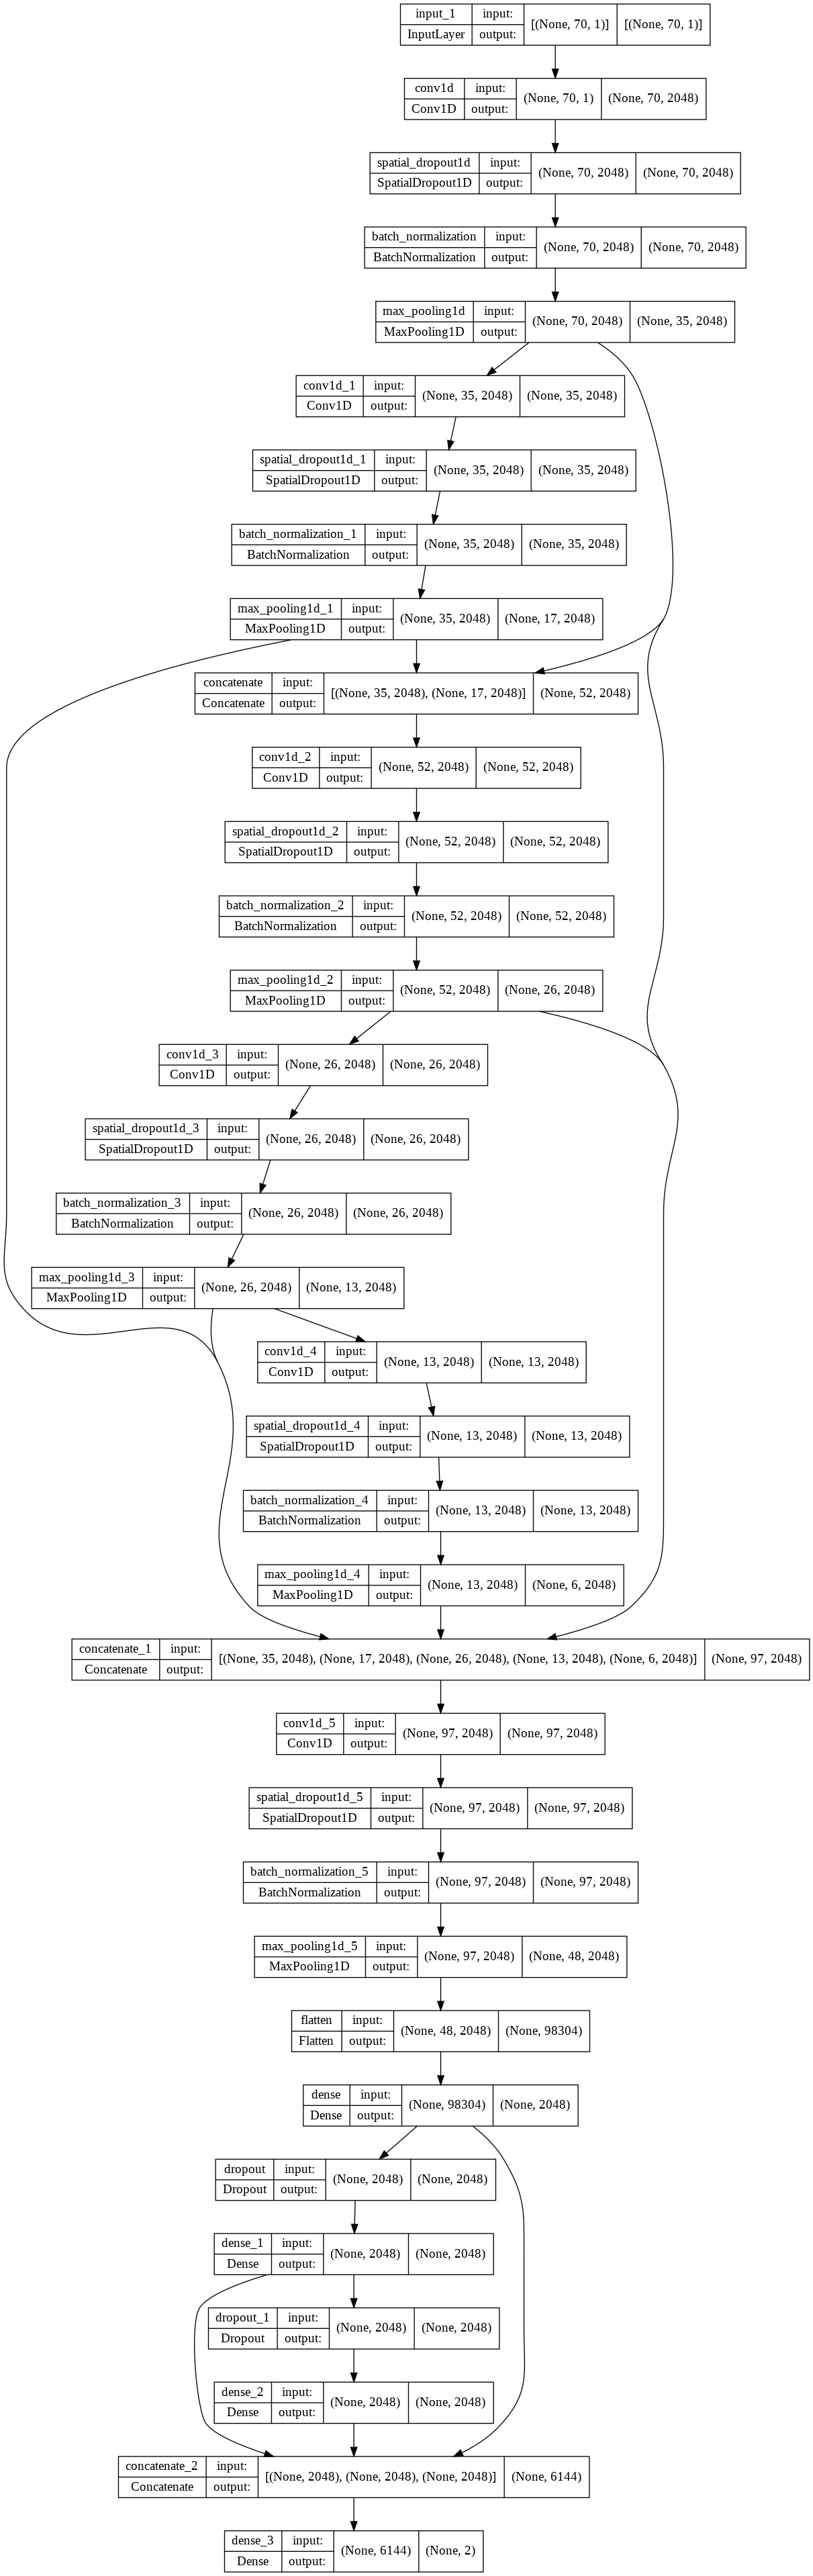

In [ ]:
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.utils.vis_utils import plot_model
from keras.layers import SpatialDropout1D


intput_shape=(70, 1) #x_train.shape[1]

input_layer = Input(intput_shape)

conv1 = Conv1D(2048, kernel_size=3,padding = 'same',activation='relu') (input_layer)
drop1 = SpatialDropout1D(0.3) (conv1)
bn1 = BatchNormalization() (drop1)
pool1 = MaxPooling1D(pool_size=(2)) (bn1)

conv2 = Conv1D(2048,kernel_size=3,padding = 'same', activation='relu') (pool1)
drop2 = SpatialDropout1D(0.3) (conv2)
bn2 = BatchNormalization() (drop2)
pool2 = MaxPooling1D(pool_size=(2)) (bn2)

connect1 = concatenate([pool1, pool2], axis=1)

conv3 = Conv1D(2048,kernel_size=3,padding = 'same', activation='relu') (connect1)
drop3 = SpatialDropout1D(0.3) (conv3)
bn3 = BatchNormalization() (drop3)
pool3 = MaxPooling1D(pool_size=(2)) (bn3)

conv4 = Conv1D(2048,kernel_size=3,padding = 'same', activation='relu') (pool3)
drop4 = SpatialDropout1D(0.3) (conv4)
bn4 = BatchNormalization() (drop4)
pool4 = MaxPooling1D(pool_size=(2)) (bn4)

conv5 = Conv1D(2048,kernel_size=3,padding = 'same', activation='relu') (pool4)
drop5 = SpatialDropout1D(0.3) (conv5)
bn5 = BatchNormalization() (drop5)
pool5 = MaxPooling1D(pool_size=(2)) (bn5)

connect2 = concatenate([pool1, pool2, pool3, pool4, pool5], axis=1)

conv6 = Conv1D(2048,kernel_size=6,padding = 'same', activation='relu') (connect2)
drop6 = SpatialDropout1D(0.3) (conv6)
bn6 = BatchNormalization() (drop6)
pool6 = MaxPooling1D(pool_size=(2)) (bn6)

flat = Flatten() (pool6)

dense1 = Dense(2048, activation='relu') (flat)
drop1 = Dropout(0.4) (dense1)

dense2 = Dense(2048, activation='relu') (drop1)
drop2 = Dropout(0.4) (dense2)

dense3 = Dense(2048, activation='relu') (drop2)
drop3 = Dropout(0.4) (dense3)

connect4 = concatenate([dense1, dense2, dense3])

output_layer = Dense(2, activation='softmax') (connect4) #num_classes

model = Model(input_layer, output_layer)
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

# Automatic save
**We have saved all the details of every epoch in google drive so that we can use this when we need.**


automatic save for Model 1

In [ ]:
# check points and early stopping
from keras.callbacks import ModelCheckpoint,EarlyStopping

model_name = ""
filepath="/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/Residual_Connection_1_100_epoch/1st_run/"  + model_name + "weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5"
print(filepath)
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=25)
callbacks_list = [es, checkpoint]

/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/Residual_Connection_1_100_epoch/1st_run/weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5


automatic save for Model 2

In [ ]:
# check points and early stopping
from keras.callbacks import ModelCheckpoint,EarlyStopping

model_name = ""
filepath="/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/Residual_Connection_2_100_epoch/1st_run/"  + model_name + "weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5"
print(filepath)
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=25)
callbacks_list = [es, checkpoint]

/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/Residual_Connection_2_100_epoch/1st_run/weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5


automatic save for Model 3

In [ ]:
# check points and early stopping
from keras.callbacks import ModelCheckpoint,EarlyStopping

model_name = ""
filepath="/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/Example 3.2/100_epochs/"  + model_name + "weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5"
print(filepath)
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=15)
callbacks_list = [es, checkpoint]

/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/Example 3.2/100_epochs/weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5


**Automatic save for multitask model only**


automatic save for model 2.4 (multitask learning)

In [ ]:
# check points and early stopping
from keras.callbacks import ModelCheckpoint,EarlyStopping

model_name = ""
filepath="/content/drive/Shareddrives/DEAP EEG/Models Saved/Multitask/documentation_model_2.4_epochs_10/"  + model_name + "weights-improvement-{epoch:02d}.hdf5"
print(filepath)
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=False, mode='auto')
#es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=25)
callbacks_list = [checkpoint]

/content/drive/Shareddrives/DEAP EEG/Models Saved/Multitask/documentation_model_2.4_epochs_10/weights-improvement-{epoch:02d}.hdf5


automatic save weights & history for model 2.4 (multitask learning)

In [ ]:
# check points and early stopping
from keras.callbacks import ModelCheckpoint,EarlyStopping

if count==0:
  count=count+1
else:
  dictionary_path = "/content/drive/Shareddrives/DEAP EEG/Models Saved/Multitask/3class_conference/2nd_run_2class/2nd_run_history_2class/" + "history-dictionary-{epoch:02d}"
  with open(dictionary_path, 'wb') as file_pi:
          pickle.dump(H.history, file_pi)

model_name = ""
filepath="/content/drive/Shareddrives/DEAP EEG/Models Saved/Multitask/3class_conference/2nd_run_2class/"  + model_name + "weights-improvement-{epoch:02d}.hdf5"
print(filepath)
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=False, mode='auto')
#es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=25)
callbacks_list = [checkpoint]

/content/drive/Shareddrives/DEAP EEG/Models Saved/Multitask/3class_conference/2nd_run_2class/weights-improvement-{epoch:02d}.hdf5


#Fit the model


fit the model 1

In [ ]:
H = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=100,
          verbose=1,
          callbacks= callbacks_list)

Epoch 1/100
2135/2135 [==============================] - ETA: 0s - loss: 0.6095 - accuracy: 0.6504
Epoch 00001: accuracy improved from -inf to 0.65044, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/Residual_Connection_1_100_epoch/1st_run/weights-improvement-01-0.6504.hdf5
2135/2135 [==============================] - 304s 138ms/step - loss: 0.6095 - accuracy: 0.6504
Epoch 2/100
2135/2135 [==============================] - ETA: 0s - loss: 0.5090 - accuracy: 0.7340
Epoch 00002: accuracy improved from 0.65044 to 0.73399, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/Residual_Connection_1_100_epoch/1st_run/weights-improvement-02-0.7340.hdf5
2135/2135 [==============================] - 294s 138ms/step - loss: 0.5090 - accuracy: 0.7340
Epoch 3/100
2135/2135 [==============================] - ETA: 0s - loss: 0.4073 - accuracy: 0.7996
Epoch 00003: accuracy improved from 0.73399 to 0.79958, saving model to /content/drive/Shareddrives/DEAP E

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2440/2440 [==============================] - 23s 9ms/step - loss: 0.2360 - accuracy: 0.9657
Test loss: 0.23595060408115387
Test accuracy: 0.9656762480735779


fit the model 2

In [ ]:
H = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=100,
          verbose=1,
          callbacks= callbacks_list)

Epoch 1/100
2135/2135 [==============================] - ETA: 0s - loss: 0.6188 - accuracy: 0.6428
Epoch 00001: accuracy improved from -inf to 0.64278, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/Residual_Connection_2_100_epoch/1st_run/weights-improvement-01-0.6428.hdf5
2135/2135 [==============================] - 246s 111ms/step - loss: 0.6188 - accuracy: 0.6428
Epoch 2/100
2135/2135 [==============================] - ETA: 0s - loss: 0.5215 - accuracy: 0.7250
Epoch 00002: accuracy improved from 0.64278 to 0.72499, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/Residual_Connection_2_100_epoch/1st_run/weights-improvement-02-0.7250.hdf5
2135/2135 [==============================] - 236s 110ms/step - loss: 0.5215 - accuracy: 0.7250
Epoch 3/100
2135/2135 [==============================] - ETA: 0s - loss: 0.4241 - accuracy: 0.7886
Epoch 00003: accuracy improved from 0.72499 to 0.78865, saving model to /content/drive/Shareddrives/DEAP E

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2440/2440 [==============================] - 20s 8ms/step - loss: 0.1923 - accuracy: 0.9702
Test loss: 0.19234058260917664
Test accuracy: 0.9702100157737732


fit the model 3

In [ ]:
H = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=100,
          verbose=1,
          callbacks= callbacks_list)

Epoch 1/100
2135/2135 [==============================] - ETA: 0s - loss: 0.5702 - accuracy: 0.6758
Epoch 00001: accuracy improved from -inf to 0.67576, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/Example 3.2/100_epochs/weights-improvement-01-0.6758.hdf5
2135/2135 [==============================] - 290s 136ms/step - loss: 0.5702 - accuracy: 0.6758
Epoch 2/100
2135/2135 [==============================] - ETA: 0s - loss: 0.4909 - accuracy: 0.7488
Epoch 00002: accuracy improved from 0.67576 to 0.74883, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/Example 3.2/100_epochs/weights-improvement-02-0.7488.hdf5
2135/2135 [==============================] - 289s 136ms/step - loss: 0.4909 - accuracy: 0.7488
Epoch 3/100
2135/2135 [==============================] - ETA: 0s - loss: 0.3741 - accuracy: 0.8234
Epoch 00003: accuracy improved from 0.74883 to 0.82339, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/Example 3.

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2440/2440 [==============================] - 15s 6ms/step - loss: 0.3034 - accuracy: 0.9663
Test loss: 0.3033607602119446
Test accuracy: 0.9663422107696533


**Importing a library for multitask model only**

In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

**Fit the model for multitasking model ony**

There is 1 data input and 5 label as training label

Here model 2.4 (multitask model) is being fitted.
Sometimes it throws valueerror like the following.

---


ValueError: Missing data for input "input_3". You passed a data dictionary with keys ['input_1']. Expected the following keys: ['input_3']

---


If error occurs then need to change the input label with the mentioned expected keys here and to the model evaluation as well.

In [ ]:
H = model.fit( {'input_1': x_train},
              {'valence': y1_train,
               'arousal': y2_train,
                'dominance': y3_train,
                'liking': y4_train,
                'familiarity': y5_train
               },
          batch_size=batch_size,
          epochs=100,
          verbose=1,
          callbacks= [callbacks_list,tensorboard_callback])

Epoch 1/100
1935/1935 [==============================] - ETA: 0s - loss: 3.4190 - valence_loss: 0.5989 - arousal_loss: 0.5715 - dominance_loss: 0.5575 - liking_loss: 0.5466 - familiarity_loss: 1.1446 - valence_accuracy: 0.6660 - arousal_accuracy: 0.6979 - dominance_accuracy: 0.7002 - liking_accuracy: 0.7085 - familiarity_accuracy: 0.5402
Epoch 1: saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Multitask/3class_conference/2nd_run_2class/weights-improvement-01.hdf5
1935/1935 [==============================] - 326s 163ms/step - loss: 3.4190 - valence_loss: 0.5989 - arousal_loss: 0.5715 - dominance_loss: 0.5575 - liking_loss: 0.5466 - familiarity_loss: 1.1446 - valence_accuracy: 0.6660 - arousal_accuracy: 0.6979 - dominance_accuracy: 0.7002 - liking_accuracy: 0.7085 - familiarity_accuracy: 0.5402
Epoch 2/100
1935/1935 [==============================] - ETA: 0s - loss: 2.7240 - valence_loss: 0.4777 - arousal_loss: 0.4598 - dominance_loss: 0.4469 - liking_loss: 0.4466 - fam

In [ ]:
score = model.evaluate({'input_1': x_test},
              {'valence': y1_test,
               'arousal': y2_test,
                'dominance': y3_test,
                'liking': y4_test,
                'familiarity': y5_test
               }, verbose=1)
#print('Test loss:', score[0])
#print('Test accuracy:', score[1])

2212/2212 [==============================] - 99s 45ms/step - loss: 1.0073 - valence_loss: 0.1860 - arousal_loss: 0.1690 - dominance_loss: 0.1701 - liking_loss: 0.1768 - familiarity_loss: 0.3053 - valence_accuracy: 0.9685 - arousal_accuracy: 0.9710 - dominance_accuracy: 0.9719 - liking_accuracy: 0.9703 - familiarity_accuracy: 0.9524


**Find the accuracy from a savepoint**

In [ ]:
from keras.models import load_model
model_loaded = load_model('/content/drive/MyDrive/Thesis/DEAP-dataset/Saved_checkpoints_2/Copy_Valance_Check_point_2/weights-improvement-120-0.9857.hdf5')
score = model_loaded.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

**Find the accuracy from a savepoint for multitasking model only**

In [ ]:
from keras.models import load_model
model_loaded = load_model('/content/drive/Shareddrives/DEAP EEG/Models Saved/Multitask/3class_conference/2nd_run_2class/weights-improvement-99.hdf5')
score = model_loaded.evaluate({'input_1': x_test},
              {'valence': y1_test,
               'arousal': y2_test,
                'dominance': y3_test,
                'liking': y4_test,
                'familiarity': y5_test
               }, verbose=1)

2212/2212 [==============================] - 240s 105ms/step - loss: 0.9726 - valence_loss: 0.1805 - arousal_loss: 0.1588 - dominance_loss: 0.1603 - liking_loss: 0.1711 - familiarity_loss: 0.3019 - valence_accuracy: 0.9686 - arousal_accuracy: 0.9712 - dominance_accuracy: 0.9725 - liking_accuracy: 0.9705 - familiarity_accuracy: 0.9512


**Load model from a save point**

In [ ]:
from keras.models import load_model
model_loaded = load_model('/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/Residual Connection 2/Example 2.14/weights-improvement-27-0.9822.hdf5')

H = model_loaded.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=73,
          verbose=1,
          validation_split = 0.2,
          callbacks= callbacks_list)

**Load model from a save point for multitasking model only**

In [ ]:
from keras.models import load_model
model_loaded = load_model('/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/Residual Connection 2/Example 2.4/weights-improvement-50.hdf5')

H = model_loaded.fit({'input_1': x_train},
              {'valence': y1_train,
               'arousal': y2_train,
                'dominance': y3_train,
                'liking': y4_train,
                'familiarity': y5_train
               },
          batch_size=batch_size,
          epochs=50,
          verbose=1,
          validation_split = 0.2,
          callbacks= callbacks_list)

**for saving history**

In [ ]:
with open('/content/drive/Shareddrives/DEAP EEG/Models Saved/Multitask/3class_conference/2nd_run_2class/2nd_run_history_2class/trainHistoryDict_epoch_100', 'wb') as file_pi:
        pickle.dump(H.history, file_pi)

**For loading history**

In [ ]:
history = pickle.load(open('/content/drive/Shareddrives/DEAP EEG/Models Saved/Multitask/3class_conference/1st_run/trainHistoryDict_epoch_10'), "rb")

# Training Graph

##2 Class Multitask Learning

**Training accuracy and loss loss graph**

In [ ]:
import matplotlib.pyplot as plt

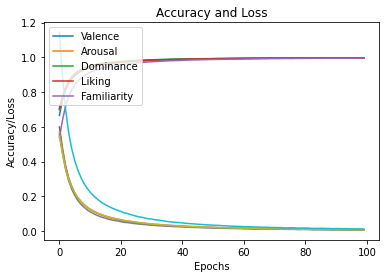

In [ ]:
plt.plot(H.history['valence_accuracy'])
plt.plot(H.history['arousal_accuracy'])
plt.plot(H.history['dominance_accuracy'])
plt.plot(H.history['liking_accuracy'])
plt.plot(H.history['familiarity_accuracy'])

plt.plot(H.history['valence_loss'])
plt.plot(H.history['arousal_loss'])
plt.plot(H.history['dominance_loss'])
plt.plot(H.history['liking_loss'])
plt.plot(H.history['familiarity_loss'])

#plt.plot(history.history['val_acc'])
plt.title('Accuracy and Loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epochs')
plt.legend(['Valence', 'Arousal','Dominance','Liking','Familiarity'], loc='upper left')
plt.savefig('accuracy and loss for 2 class.png',bbox_inches='tight',dpi=300)
plt.show()

**Training accuracy graph**

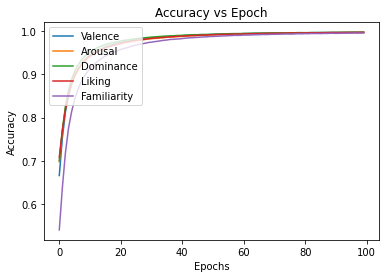

In [ ]:
plt.plot(H.history['valence_accuracy'])
plt.plot(H.history['arousal_accuracy'])
plt.plot(H.history['dominance_accuracy'])
plt.plot(H.history['liking_accuracy'])
plt.plot(H.history['familiarity_accuracy'])

plt.title('Accuracy vs Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Valence', 'Arousal','Dominance','Liking','Familiarity'], loc='upper left')
plt.savefig('Accuracy vs Epoch for 2 class.png',bbox_inches='tight',dpi=300)
plt.show()

**Training Loss graph**

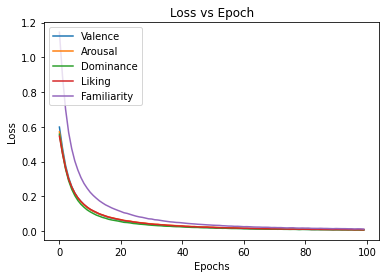

In [ ]:
plt.plot(H.history['valence_loss'])
plt.plot(H.history['arousal_loss'])
plt.plot(H.history['dominance_loss'])
plt.plot(H.history['liking_loss'])
plt.plot(H.history['familiarity_loss'])

#plt.plot(history.history['val_acc'])
plt.title('Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Valence', 'Arousal','Dominance','Liking','Familiarity'], loc='upper left')
plt.savefig('Loss vs Epoch for 2 class.png',bbox_inches='tight',dpi=300)
plt.show()

# Confusion Matrix

##2 Class Multitask Learning

**Create Confusion matrix plotting function**

In [ ]:
from sklearn.utils.multiclass import unique_labels
from matplotlib import pyplot as plt
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",fontsize=18,
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

**Valence Confusion matrix plotting function call**

Confusion matrix, without normalization
[[29852  1136]
 [ 1096 38676]]
Normalized confusion matrix
[[0.96 0.04]
 [0.03 0.97]]


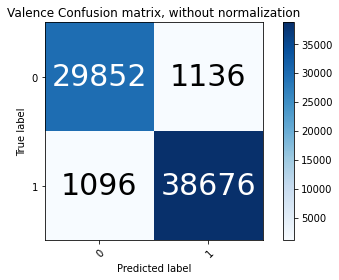

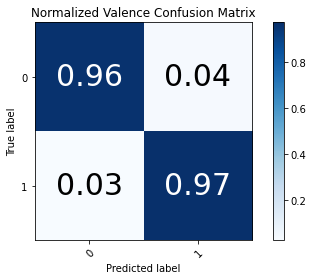

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(x_test)
y_test_argmax = y1_test.argmax(axis=1)
y_pred_argmax = y_pred[0].argmax(axis=1)

class_names = np.array([0,1])

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_argmax, y_pred_argmax, classes=class_names,
                      title='Valence Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test_argmax, y_pred_argmax, classes=class_names, normalize=True,
                      title='Normalized Valence Confusion Matrix')
plt.savefig('Normalized Valence Confusion Matrix for 2 class.png',bbox_inches='tight',dpi=300)

plt.show()

**Arousal Confusion matrix plotting function call**

Confusion matrix, without normalization
[[27253  1051]
 [ 1000 41456]]
Normalized confusion matrix
[[0.96 0.04]
 [0.02 0.98]]


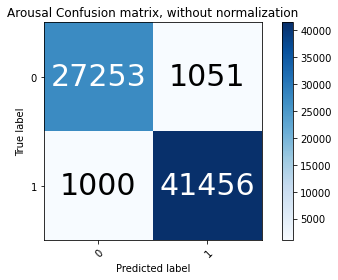

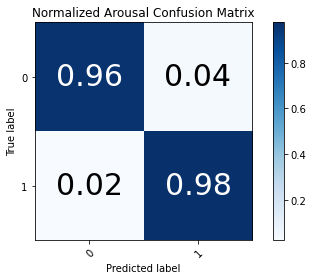

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(x_test)
y_test_argmax = y2_test.argmax(axis=1)
y_pred_argmax = y_pred[1].argmax(axis=1)

class_names = np.array([0,1])

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_argmax, y_pred_argmax, classes=class_names,
                      title='Arousal Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test_argmax, y_pred_argmax, classes=class_names, normalize=True,
                      title='Normalized Arousal Confusion Matrix')
plt.savefig('Normalized Arousal Confusion Matrix for 2 class.png',bbox_inches='tight',dpi=300)

plt.show()

**Dominance Confusion matrix plotting function call**

Confusion matrix, without normalization
[[26054  1030]
 [  955 42721]]
Normalized confusion matrix
[[0.96 0.04]
 [0.02 0.98]]


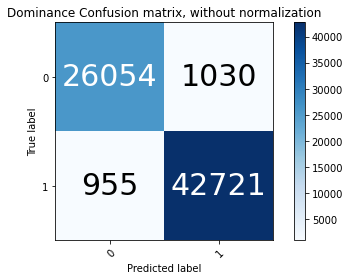

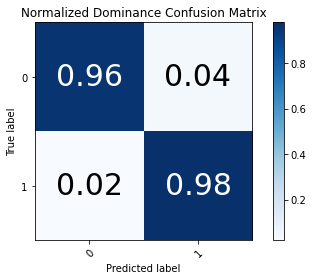

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(x_test)
y_test_argmax = y3_test.argmax(axis=1)
y_pred_argmax = y_pred[2].argmax(axis=1)

class_names = np.array([0,1])

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_argmax, y_pred_argmax, classes=class_names,
                      title='Dominance Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test_argmax, y_pred_argmax, classes=class_names, normalize=True,
                      title='Normalized Dominance Confusion Matrix')
plt.savefig('Normalized Dominance Confusion Matrix for 2 class.png',bbox_inches='tight',dpi=300)

plt.show()

**Liking Confusion matrix plotting function call**

Confusion matrix, without normalization
[[21987  1132]
 [  969 46672]]
Normalized confusion matrix
[[0.95 0.05]
 [0.02 0.98]]


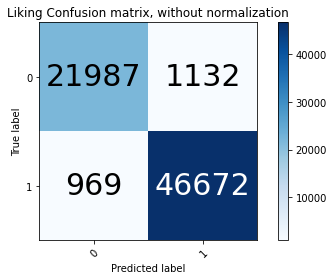

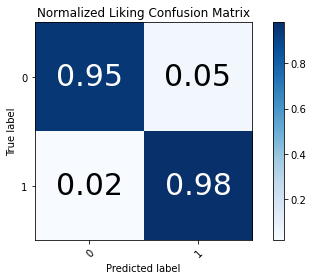

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(x_test)
y_test_argmax = y4_test.argmax(axis=1)
y_pred_argmax = y_pred[3].argmax(axis=1)

class_names = np.array([0,1])

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_argmax, y_pred_argmax, classes=class_names,
                      title='Liking Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test_argmax, y_pred_argmax, classes=class_names, normalize=True,
                      title='Normalized Liking Confusion Matrix')
plt.savefig('Normalized Liking Confusion Matrix for 2 class.png',bbox_inches='tight',dpi=300)

plt.show()

**Familiarity Confusion matrix plotting function call**

Confusion matrix, without normalization
[[33209   267   245   188   312]
 [  420  9318    86    79   101]
 [  277    73  6245    42    73]
 [  256    75    52  6979    80]
 [  434   133    84    92 11640]]
Normalized confusion matrix
[[0.97 0.01 0.01 0.01 0.01]
 [0.04 0.93 0.01 0.01 0.01]
 [0.04 0.01 0.93 0.01 0.01]
 [0.03 0.01 0.01 0.94 0.01]
 [0.04 0.01 0.01 0.01 0.94]]


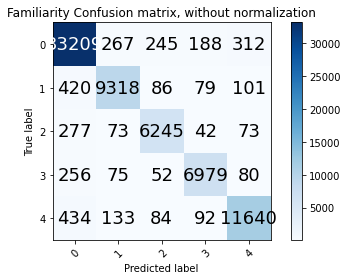

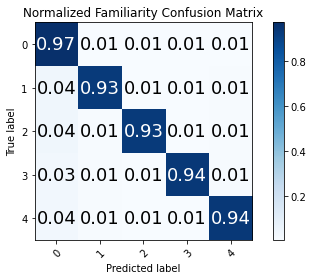

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(x_test)
y_test_argmax = y5_test.argmax(axis=1)
y_pred_argmax = y_pred[4].argmax(axis=1)

class_names = np.array([0,1,2,3,4])

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_argmax, y_pred_argmax, classes=class_names,
                      title='Familiarity Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test_argmax, y_pred_argmax, classes=class_names, normalize=True,
                      title='Normalized Familiarity Confusion Matrix')
plt.savefig('Normalized Familiarity Confusion Matrix for 2 class.png',bbox_inches='tight',dpi=300)

plt.show()

#Classification Report

##2 Class Multitask Learning

**Valence Classification Report**

In [ ]:
y_true = np.array(y1_test)
y_pred = model.predict(x_test)
y_pred = np.squeeze(y_pred[0])
y_pred = np.array(y_pred >= 0.5, dtype=np.int)

from sklearn.metrics import classification_report
print(classification_report(y1_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     30988
           1       0.97      0.97      0.97     39772

   micro avg       0.97      0.97      0.97     70760
   macro avg       0.97      0.97      0.97     70760
weighted avg       0.97      0.97      0.97     70760
 samples avg       0.97      0.97      0.97     70760



**Arousal Classification Report**

In [ ]:
y_true = np.array(y2_test)
y_pred = model.predict(x_test)
y_pred = np.squeeze(y_pred[1])
y_pred = np.array(y_pred >= 0.5, dtype=np.int)

from sklearn.metrics import classification_report
print(classification_report(y2_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     28304
           1       0.98      0.98      0.98     42456

   micro avg       0.97      0.97      0.97     70760
   macro avg       0.97      0.97      0.97     70760
weighted avg       0.97      0.97      0.97     70760
 samples avg       0.97      0.97      0.97     70760



**Dominance Classification Report**

In [ ]:
y_true = np.array(y3_test)
y_pred = model.predict(x_test)
y_pred = np.squeeze(y_pred[2])
y_pred = np.array(y_pred >= 0.5, dtype=np.int)

from sklearn.metrics import classification_report
print(classification_report(y3_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     27084
           1       0.98      0.98      0.98     43676

   micro avg       0.97      0.97      0.97     70760
   macro avg       0.97      0.97      0.97     70760
weighted avg       0.97      0.97      0.97     70760
 samples avg       0.97      0.97      0.97     70760



**Liking Classification Report**

In [ ]:
y_true = np.array(y4_test)
y_pred = model.predict(x_test)
y_pred = np.squeeze(y_pred[3])
y_pred = np.array(y_pred >= 0.5, dtype=np.int)

from sklearn.metrics import classification_report
print(classification_report(y4_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95     23119
           1       0.98      0.98      0.98     47641

   micro avg       0.97      0.97      0.97     70760
   macro avg       0.97      0.97      0.97     70760
weighted avg       0.97      0.97      0.97     70760
 samples avg       0.97      0.97      0.97     70760



**Familiarity Classification Report**

In [ ]:
y_true = np.array(y5_test)
y_pred = model.predict(x_test)
y_pred = np.squeeze(y_pred[4])
y_pred = np.array(y_pred >= 0.5, dtype=np.int)

from sklearn.metrics import classification_report
print(classification_report(y5_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97     34221
           1       0.95      0.93      0.94     10004
           2       0.93      0.93      0.93      6710
           3       0.95      0.94      0.94      7442
           4       0.95      0.94      0.95     12383

   micro avg       0.95      0.95      0.95     70760
   macro avg       0.95      0.94      0.94     70760
weighted avg       0.95      0.95      0.95     70760
 samples avg       0.95      0.95      0.95     70760

